# Analyse FEP outputs

In [1]:
# import from path (github clone) as a conda install is not available yet for freenrgworkflows.
import sys
sys.path.insert(1, './input/testsets/tnks2/fep_results/freenrgworkflows/networkanalysis/')

import networkanalysis
import experiments
import stats as FEW_stats

# import some other modules that we'll need.
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd 
from glob import glob
from tqdm.notebook import tqdm
from itertools import combinations
from scipy import stats as scistats

This notebook is derived from the BioSimSpace Tutorial held in 2021. See https://github.com/michellab/BioSimSpaceTutorials

## 1. Load FEP output data.

### Variables

In [2]:
path_to_fep_results = "./input/testsets/tnks2/fep_results/"

# experimental values (e.g. ic50/ki) for all ligands in our set. This is optional.
exp_filepath = f'{path_to_fep_results}exp_data.csv'


In [3]:
# count the number of edges per network.
for ntwk_type in ["fepnn", "lomap"]:
    edges = []
    for idx, row in pd.read_csv(f"{path_to_fep_results}/processed_summaries/summary_{ntwk_type}_1.csv").iterrows():
        pert = "~".join(row[0:2].values)
        inv_pert = "~".join([row[0:2].values[1], row[0:2].values[0]])

        if not pert in edges and not inv_pert in edges:
            edges.append(pert)
    print(f"{ntwk_type} network contained {len(edges)} edges.")


fepnn network contained 28 edges.
lomap network contained 27 edges.


## 2. Load experimental data (if available) and compile into pandas.
In cases where experimental data is available, for instance when benchmarking a new protein-ligand set, we would like to compare how well FEP is predicting with respect to these data. Using Pandas, we can work with our data in an intuitive way that is easy to use for plotting graphs.

Load the experimental data. 

In [4]:
experiments = experiments.ExperimentalData()

experiments.compute_affinities(exp_filepath, data_type="IC50", comments="#", delimiter=",")
experimental_DDGs = experiments.freeEnergiesInKcal

For plotting it is typically easier to work with the pandas library. This next bit of code reshapes the data into a dataframe format. 

Note that if pandas returns value errors at this step, it is likely there are ligands missing from either your FEP outputs or your experimental input.

In [5]:
def computePM(stats_triplet):
    """For a list of three values where the middle value is the mean and the outer values are the outer bounds,
    return the mean and the plus-minus as the mean error of the bounds compared to the mean."""
    mean_val = stats_triplet[1]
    error_1 = mean_val - stats_triplet[0]
    error_2 = stats_triplet[2] - mean_val 
    mean_err = np.mean([error_1, error_2])
    
    return round(mean_val, 2), round(mean_err, 2)

In [6]:
def runChunk(fep_summary_path, exp_ddgs):
    """Given a summary file, run FreeEnergyWorkflows and return stats."""

    fepnn_summary = fep_summary_path
    nA = networkanalysis.NetworkAnalyser()
    nA.read_perturbations_pandas(fepnn_summary, comments='#')
    comp_ddgs = nA.freeEnergyInKcal
    
    # compute boostrapped statistics.
    _stats_obj = FEW_stats.freeEnergyStats()
    _stats_obj.generate_statistics(comp_ddgs, exp_ddgs, repeats=100000)
    r_val, r_conf = computePM(_stats_obj.R_confidence)
    mue_val, mue_conf = computePM(_stats_obj.mue_confidence)
    tau_val, tau_conf = computePM(_stats_obj.tau_confidence)
    return r_val, mue_val, tau_val

In [7]:
def appendToDict(value, key, ref_dict):
    """"Adds a value to a dict; appends if key already in dict"""
    if not key in ref_dict:
        ref_dict[key] = [value]
    else:
        ref_dict[key].append(value)
    return ref_dict

In [8]:
def getRepStats(rep_dict):
    """Given a dict where keys are rep numbers and values are stats, compute the mean stat per key"""
    mean_stats = []
    sems = []
    for i in range(1, 6):
        mean_stats.append(np.mean(rep_dict[i]))
        sems.append(scistats.sem(rep_dict[i]))
    return mean_stats, sems

In [9]:
r_dict_fepnn = {}
mue_dict_fepnn = {}
tau_dict_fepnn = {}

r_dict_lomap = {}
mue_dict_lomap = {}
tau_dict_lomap = {}

# load FEP results into FEW and compute ddGs using WLS regression.
for i in tqdm(range(1, 6)):
    # make all possible combinations of the 5 replicates.
    for cnts in combinations([1,2,3,4,5], i):
        cnts = [str(i) for i in cnts]
        fep_summary_path = f"{path_to_fep_results}/processed_summaries/summary_fepnn_{''.join(cnts)}.csv"
            
        r_val, mue_val, tau_val = runChunk(fep_summary_path, experimental_DDGs)
        appendToDict(r_val, len(cnts), r_dict_fepnn)
        appendToDict(mue_val, len(cnts), mue_dict_fepnn)
        appendToDict(tau_val, len(cnts), tau_dict_fepnn)

        # now do the same for LOMAP network.
        fep_summary_path = f"{path_to_fep_results}/processed_summaries/summary_lomap_{''.join(cnts)}.csv"
            
        r_val, mue_val, tau_val = runChunk(fep_summary_path, experimental_DDGs)
        appendToDict(r_val, len(cnts), r_dict_lomap)
        appendToDict(mue_val, len(cnts), mue_dict_lomap)
        appendToDict(tau_val, len(cnts), tau_dict_lomap)

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# now get arrays of mean statistic per number of replicates per statistic type.
# runtimewarnings are expected because the code tries to compute SEM on a single-value array once.
r_vals_fepnn, r_confs_fepnn = getRepStats(r_dict_fepnn)
mue_vals_fepnn, mue_confs_fepnn = getRepStats(mue_dict_fepnn)
tau_vals_fepnn, tau_confs_fepnn = getRepStats(tau_dict_fepnn)

r_vals_lomap, r_confs_lomap = getRepStats(r_dict_lomap)
mue_vals_lomap, mue_confs_lomap = getRepStats(mue_dict_lomap)
tau_vals_lomap, tau_confs_lomap = getRepStats(tau_dict_lomap)

/Users/jscheen/miniconda3/envs/biosimspace-dev/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/jscheen/miniconda3/envs/biosimspace-dev/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


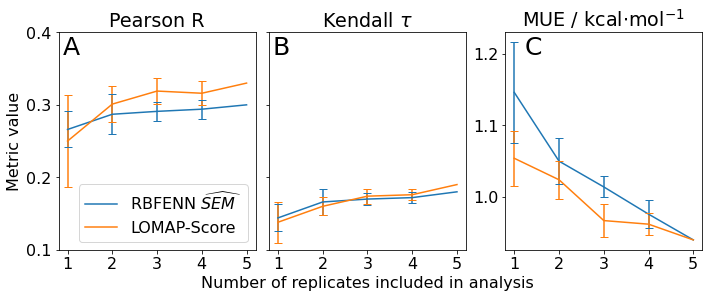

In [19]:
f, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.rcParams.update({'font.size': 16,})


# fepnn r
axes[0].plot(["1","2","3","4","5"], r_vals_fepnn, color="tab:blue", label="RBFENN $\widehat{SEM}$")
axes[0].errorbar(["1","2","3","4","5"], r_vals_fepnn, color="tab:blue", yerr=r_confs_fepnn, fmt="none", capsize=4)

# lomap r
axes[0].plot(["1","2","3","4","5"], r_vals_lomap, color="tab:orange", label="LOMAP-Score")
axes[0].errorbar(["1","2","3","4","5"], r_vals_lomap, color="tab:orange", yerr=r_confs_lomap, fmt="none", capsize=4)


#############
# fepnn tau
axes[1].plot(["1","2","3","4","5"], tau_vals_fepnn, color="tab:blue", label="RBFENN $\widehat{SEM}$")
axes[1].errorbar(["1","2","3","4","5"], tau_vals_fepnn, color="tab:blue", yerr=tau_confs_fepnn, fmt="none", capsize=4)

# lomap tau
axes[1].plot(["1","2","3","4","5"], tau_vals_lomap, color="tab:orange", label="LOMAP-Score")
axes[1].errorbar(["1","2","3","4","5"], tau_vals_lomap, color="tab:orange", yerr=tau_confs_lomap, fmt="none", capsize=4)
#############


#############
# fepnn mue
axes[2].plot(["1","2","3","4","5"], mue_vals_fepnn, color="tab:blue", label="RBFENN $\widehat{SEM}$")
axes[2].errorbar(["1","2","3","4","5"], mue_vals_fepnn, color="tab:blue", yerr=mue_confs_fepnn, fmt="none", capsize=4)

# lomap mue
axes[2].plot(["1","2","3","4","5"], mue_vals_lomap, color="tab:orange", label="LOMAP-Score")
axes[2].errorbar(["1","2","3","4","5"], mue_vals_lomap, color="tab:orange", yerr=mue_confs_lomap, fmt="none", capsize=4)
#############


# annotate.
axes[0].annotate("A", xy=(0.02, 0.9), xycoords="axes fraction", size=25)
axes[1].annotate("B", xy=(0.02, 0.9), xycoords="axes fraction", size=25)
axes[2].annotate("C", xy=(0.1, 0.9), xycoords="axes fraction", size=25)

# further formatting.
axes[0].legend()
axes[1].set_xlabel("Number of replicates included in analysis")
axes[0].set_title("Pearson R")
axes[1].set_title(r"Kendall $\tau$")
axes[2].set_title("MUE / kcal$\cdot$mol$^{-1}$")
axes[0].set_ylabel("Metric value")

# share axes between left and center.
axes[0].set_ylim(0.1, 0.4)
axes[1].set_ylim(0.1, 0.4)

axes[1].set_yticklabels([])
# shift axes
box = axes[1].get_position()
box.x0 = box.x0 - 0.03
box.x1 = box.x1 - 0.03
axes[1].set_position(box)
box = axes[2].get_position()
box.x0 = box.x0 - 0.03
box.x1 = box.x1 - 0.03
axes[2].set_position(box)


plt.savefig("../../figures/tnks_ddg_lineplots.png", dpi=300, bbox_inches = "tight")


# plt.tight_layout()
plt.show()

## Compare SOMD edge ddGs with Cresset edge ddGs

In [13]:
from sklearn.metrics import mean_absolute_error

In [14]:
somd_edges = {}
somd_summary_files = glob(f"{path_to_fep_results}summaries/summary_*.csv")

for somd_summary in somd_summary_files:
    with open(somd_summary, "r") as readfile:
        reader = csv.reader(readfile)
        for row in reader:
            if row[0] == "lig_1":
                continue # skip headers
            
            # get the pert name and add the FE prediction to the somd dict.
            pert = "~".join([row[0], row[1]])
            if not pert in somd_edges:
                somd_edges[pert] = [float(row[2])]
            else:
                somd_edges[pert].append(float(row[2]))
                
# for each edge, take the mean FE prediction.
for pert, fe_preds in somd_edges.items():
    somd_edges[pert] = np.mean(fe_preds)

In [15]:
# now get the edge ddG predictions as provided by Cresset.
cresset_edges = {}
with open("./input/testsets/tnks2/cresset_ddgs.csv", "r") as readfile:
    reader = csv.reader(readfile)
    # columns are [pertname, forward FE pred, backward FE pred].
    for pert, fe_fwd, fe_bckwd in reader:
        inv_pert = "~".join([pert.split("~")[1], pert.split("~")[0]])
        
        cresset_edges[pert] = float(fe_fwd)
        cresset_edges[inv_pert] = float(fe_bckwd)        

In [16]:
# now find overlapping edges.
somd_fe_preds = []
cresset_fe_preds = []

for pert, somd_pred in somd_edges.items():
    if pert in cresset_edges:
        somd_fe_preds.append(somd_pred)
        cresset_fe_preds.append(cresset_edges[pert])

R ~ 0.71
MUE ~ 0.93 kcal/mol
Tau ~ 0.42


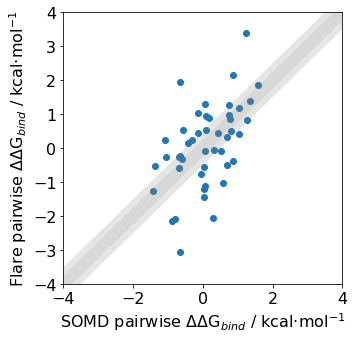

In [17]:
f, ax = plt.subplots(figsize=(5,5))
plt.scatter(somd_fe_preds, cresset_fe_preds)
plt.xlim(-4,4)
plt.ylim(-4,4)

# plot 1/2 kcal bounds:
ax.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=2,
                alpha=0.3,
                color="grey")
# upper bound:
ax.fill_between(
                x=[-100, 100], 
                y2=[-99.5,100.5],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=2,
                color="grey", 
                alpha=0.2)
# lower bound:
ax.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-100.5, 99.5],
                lw=0, 
                zorder=2,
                color="grey", 
                alpha=0.2)


plt.xlabel("SOMD pairwise $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.ylabel("Flare pairwise $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

print(f"R ~ {round(scistats.pearsonr(somd_fe_preds, cresset_fe_preds)[0], 2)}")
print(f"MUE ~ {round(mean_absolute_error(somd_fe_preds, cresset_fe_preds), 2)} kcal/mol")
print(f"Tau ~ {round(scistats.kendalltau(somd_fe_preds, cresset_fe_preds)[0], 2)}")

plt.show()